# MESQUAL 301: Time Series Dashboard

This notebook demonstrates the TimeSeriesDashboard module for effective visualization of complex time-series data across multiple dimensions, such as multi-scenario and multi-object time-series DataFrames. 

The TimeSeriesDashboard module can be used as a standalone module and does not require the use of any further MESQUAL modules, so it can be used outside of the KPI framework, as well as outside of the StudyManager and Dataset framework. You can use this module with any time-series that you have in a pd DataFrame format with a DatetimeIndex. In fact, for the examples, we will use an example time-series from one of TU-Berlins public lecture documents.

Key features of TimeSeriesDashboard:
- Heatmap visualization of time-series patterns
- Multi-faceted display for comparing scenarios and variables, following the plotly-express framework of facet_row and facet_col
- Flexible time-horizon aggregation (daily, weekly, monthly) combined with flexible statistical aggregations (e.g. mean, min, max, ...)
- Statistical summaries alongside visualizations, fully customizable
- Customizable color scales, optionally even per facet category

## Setup

First, we need to set up the environment. If you are on Colab, the first cell will clone and install all dependencies. You will have to restart the session afterwards and continue with cell 2. If you are in a local environment, make sure that you have followed the Getting started steps in the README, so that mesqual and all requirements are installed.

In [1]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import importlib.util

    def is_module_available(module_name):
        return importlib.util.find_spec(module_name) is not None

    if os.path.exists("mesqual-vanilla-studies") and is_module_available("mesqual"):
        print("✅ Environment already set up. Skipping installation.")
    else:
        print("🔧 Setting up Colab environment...")
        !git clone --recursive https://github.com/helgeesch/mesqual-vanilla-studies.git
        %cd mesqual-vanilla-studies/

        !pip install git+https://github.com/helgeesch/mesqual -U
        !pip install git+https://github.com/helgeesch/mesqual-pypsa -U
        !pip install git+https://github.com/helgeesch/captain-arro -U
        !pip install -r requirements.txt

        print('✅ Setup complete. 🔁 Restart the session, then skip this cell and continue with the next one.')
else:
    print("🖥️ Running locally. No setup needed.")

Running locally, let's continue.


In [2]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import sys
    sys.path.append('/content/mesqual-vanilla-studies')
    os.chdir('/content/mesqual-vanilla-studies')
else:
    def setup_notebook_env():
        """Set working directory to repo root and ensure it's in sys.path."""
        import os
        import sys
        from pathlib import Path

        def find_repo_root(start_path: Path) -> Path:
            current = start_path.resolve()
            while current != current.parent:
                if (current / 'vanilla').exists():
                    return current
                current = current.parent
            raise FileNotFoundError(f"Repository root not found from: {start_path}")

        repo_root = find_repo_root(Path.cwd())
        os.chdir(repo_root)
        if str(repo_root) not in sys.path:
            sys.path.insert(0, str(repo_root))

    setup_notebook_env()

try:
    from mesqual import StudyManager
except ImportError:
    raise ImportError("❌ 'mesqual' not found. If you're running locally, make sure you've installed all dependencies as described in the README.")

if not os.path.isdir("studies"):
    raise RuntimeError(f"❌ 'studies' folder not found. Make sure your working directory is set to the mesqual-vanilla-studies root. Current working directory: {os.getcwd()}")

print("✅ Environment ready. Let’s go!")

✅ Environment ready. Let’s go!


In [3]:
import os
import pandas as pd

from mesqual.visualizations.plotly_figures import TimeSeriesDashboardGenerator
from mesqual.utils.plotly_utils.plotly_theme import PlotlyTheme
from mesqual.utils.pandas_utils import xs_df
from vanilla.notebook_config import configure_clean_output_for_jupyter_notebook
from vanilla.conditional_renderer import ConditionalRenderer

configure_clean_output_for_jupyter_notebook()
PlotlyTheme().apply()
renderer = ConditionalRenderer(height=800, width=1600)

## Loading Example Data

We'll work with renewable energy generation and market data from TU-Berlin for our examples.

In [4]:
# Load sample data
url = "https://tubcloud.tu-berlin.de/s/pKttFadrbTKSJKF/download/time-series-lecture-2.csv"
df_raw = pd.read_csv(url, index_col=0, parse_dates=True).rename_axis('variable', axis=1)

# Create scenario dataset with variations
df_raw_scenarios = pd.concat(
    {
        'base': df_raw,
        'scen1': df_raw ** 0.5,  # numerical transformation to mock a "scenario"
        'scen2': df_raw ** 0.2,  # numerical transformation to mock a "scenario"
    },
    axis=1,
    names=['dataset']
)

# Create dataset with renewable generation (as percentages)
df_res = df_raw[['onwind', 'offwind', 'solar']].copy() * 100
# Remove one data point to show handling of missing data
df_res_scenarios = xs_df(df_raw_scenarios.copy(), ['onwind', 'offwind', 'solar'], level='variable', axis=1).drop(('scen1', 'offwind'), axis=1)

# Create mixed dataset with price, load, and solar data
df_mixed = df_raw[['prices', 'load', 'solar']].copy()
df_mixed['solar'] *= 100  # Convert solar to percentage
df_mixed_scenarios = xs_df(df_raw_scenarios.copy(), ['prices', 'load', 'solar'], level='variable', axis=1)
for c in df_mixed_scenarios.columns:
    if 'solar' in c:
        df_mixed_scenarios[c] *= 100

In [5]:
# Display RES ts
print("Renewable generation data shape:", df_res.shape, "\n")
print(df_res.head())

Renewable generation data shape: (8760, 3) 

variable             onwind  offwind  solar
2015-01-01 00:00:00   15.66    70.30    0.0
2015-01-01 01:00:00   16.59    68.75    0.0
2015-01-01 02:00:00   17.46    65.35    0.0
2015-01-01 03:00:00   17.45    68.03    0.0
2015-01-01 04:00:00   18.26    72.72    0.0


In [6]:
print("Mixed data shape:", df_mixed.shape, "\n")
print(df_mixed.tail())

Mixed data shape: (8760, 3) 

variable             prices   load  solar
2015-12-31 19:00:00   36.79  47.72    0.0
2015-12-31 20:00:00   28.81  45.91    0.0
2015-12-31 21:00:00   26.27  45.61    0.0
2015-12-31 22:00:00   29.99  43.76    0.0
2015-12-31 23:00:00   31.59  41.91    0.0


In [7]:
print("Scenarios RES data shape:", df_res_scenarios.shape, "\n")
print(df_res_scenarios.head())

Scenarios RES data shape: (8760, 8) 

dataset               base                ...  scen2              
variable            onwind offwind solar  ... onwind offwind solar
2015-01-01 00:00:00   0.16    0.70   0.0  ...   0.69    0.93   0.0
2015-01-01 01:00:00   0.17    0.69   0.0  ...   0.70    0.93   0.0
2015-01-01 02:00:00   0.17    0.65   0.0  ...   0.71    0.92   0.0
2015-01-01 03:00:00   0.17    0.68   0.0  ...   0.71    0.93   0.0
2015-01-01 04:00:00   0.18    0.73   0.0  ...   0.71    0.94   0.0

[5 rows x 8 columns]


In [8]:
print("Scenarios Mixed data shape:", df_mixed_scenarios.shape, "\n")
print(df_mixed_scenarios.head())

Scenarios Mixed data shape: (8760, 9) 

dataset               base               ... scen2             
variable              load solar prices  ...  load solar prices
2015-01-01 00:00:00  41.15   0.0    NaN  ...  2.10   0.0    NaN
2015-01-01 01:00:00  40.13   0.0    NaN  ...  2.09   0.0    NaN
2015-01-01 02:00:00  39.11   0.0    NaN  ...  2.08   0.0    NaN
2015-01-01 03:00:00  38.77   0.0    NaN  ...  2.08   0.0    NaN
2015-01-01 04:00:00  38.94   0.0    NaN  ...  2.08   0.0    NaN

[5 rows x 9 columns]


## Basic TimeSeriesDashboard Visualization

Let's visualize hourly patterns throughout different time periods, with variables organized as facet rows.

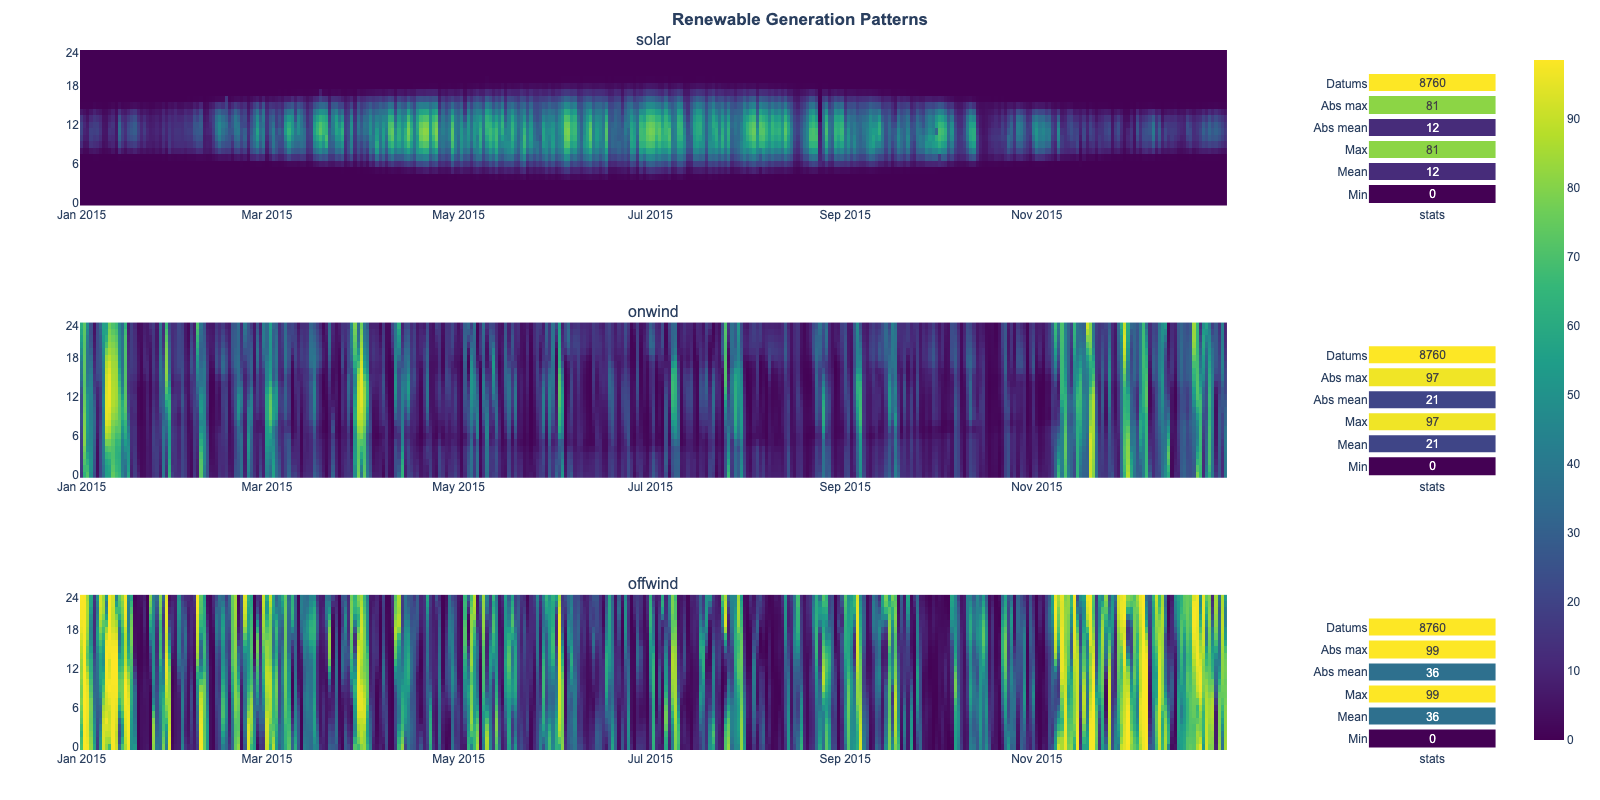

In [9]:
# Basic visualization with variables as rows
generator = TimeSeriesDashboardGenerator(
    x_axis='date',                      # X-axis per date (other options are aggregations per: week, month, year_week, year_month)
    color_continuous_scale='viridis',   # Color scale
    facet_row='variable',               # Each variable gets its own row
    facet_row_order=['solar', 'onwind', 'offwind']
)

fig = generator.get_figure(df_res, title='Renewable Generation Patterns')

renderer.show_plotly(fig)

You can see a dashboard with three time-series visualizations as heatmaps and some KPIs right next to the heatmaps. The time-series heatmaps have the date on the x-axis and the time of the day on the y-axis. This enables you to quickly understand any intra-daily patterns, such as the one of the solar profile.

The stats on the right-hand side are an efficient way to immediately understand some KPIs for each time-series, and how they differ between the different variables. 

## Custom Statistics in stats column

You can fully customize the statistics shown in the stats column on the dashbaord. The Config has a default set and a library of pre-implemented statistical aggregations (feel free to check out). Custom aggregations can be implemented as needed, you just need to provide a callable for a pandas series that returns the KPI.

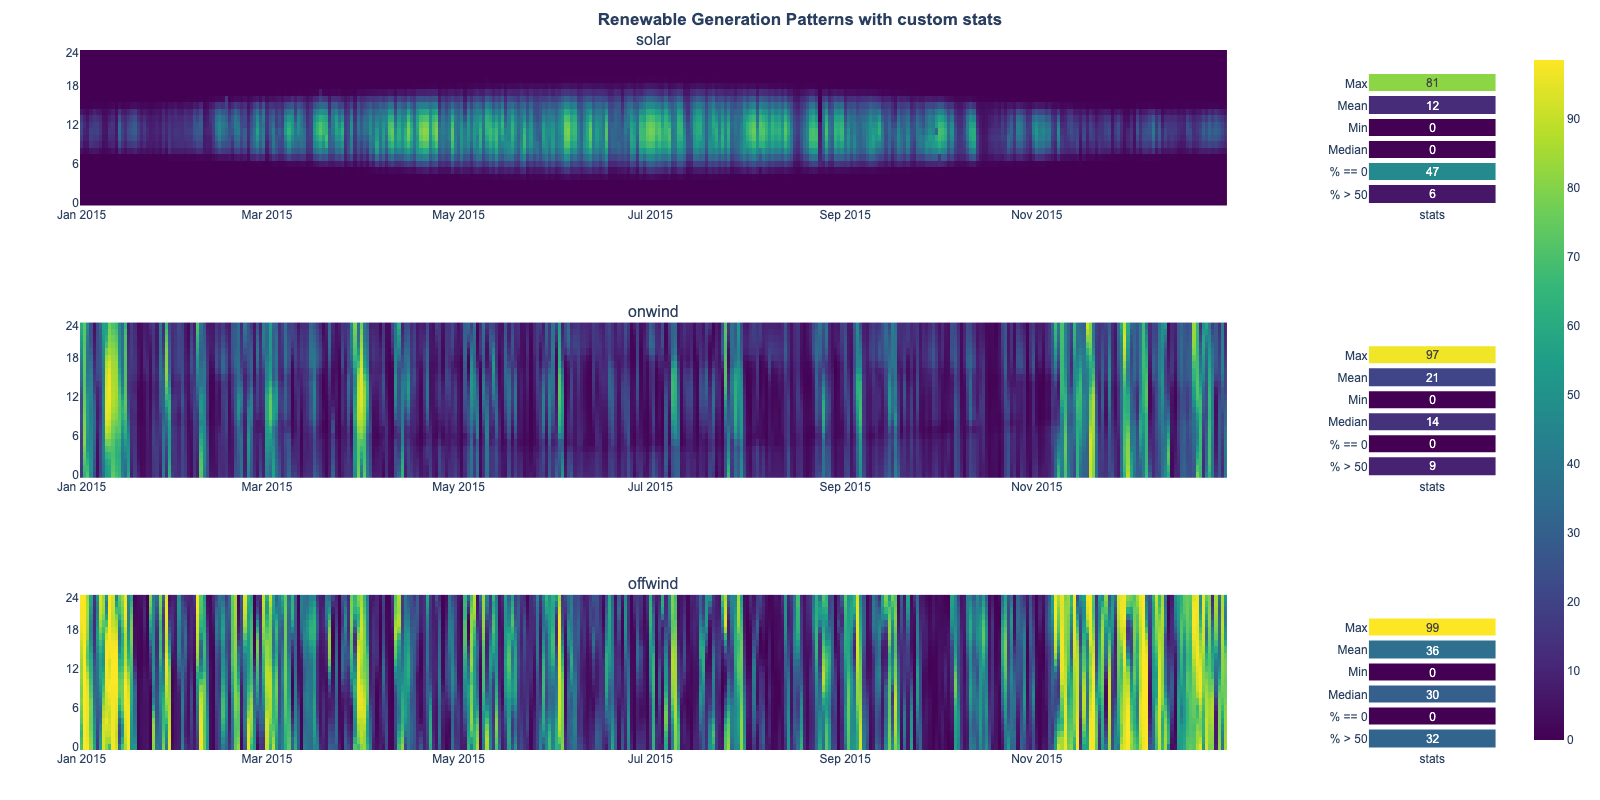

In [10]:
from mesqual.visualizations.plotly_figures.timeseries_dashboard import DashboardConfig

stats = DashboardConfig.DEFAULT_STATISTICS.copy()
stats.pop('Datums')
stats.pop('Abs max')
stats.pop('Abs mean')
stats['Median'] = DashboardConfig.STATISTICS_LIBRARY['Median']
stats['% == 0'] = lambda x: (x == 0).sum() / len(x) * 100  # custom agg should be a callable of a pd.Series
stats['% > 50'] = lambda x: (x > 50).sum() / len(x) * 100  # custom agg should be a callable of a pd.Series

# Basic visualization with custom set of stats
generator = TimeSeriesDashboardGenerator(
    x_axis='date',                      # X-axis per date (other options are aggregations per: week, month, year_week, year_month)
    color_continuous_scale='viridis',   # Color scale
    facet_row='variable',               # Each variable gets its own row
    facet_row_order=['solar', 'onwind', 'offwind'],
    stat_aggs=stats,
)

fig = generator.get_figure(df_res, title='Renewable Generation Patterns with custom stats')

renderer.show_plotly(fig)

## Facet Column Layouts

Instead of rows, we can also organize variables as columns, giving full control over the layout.

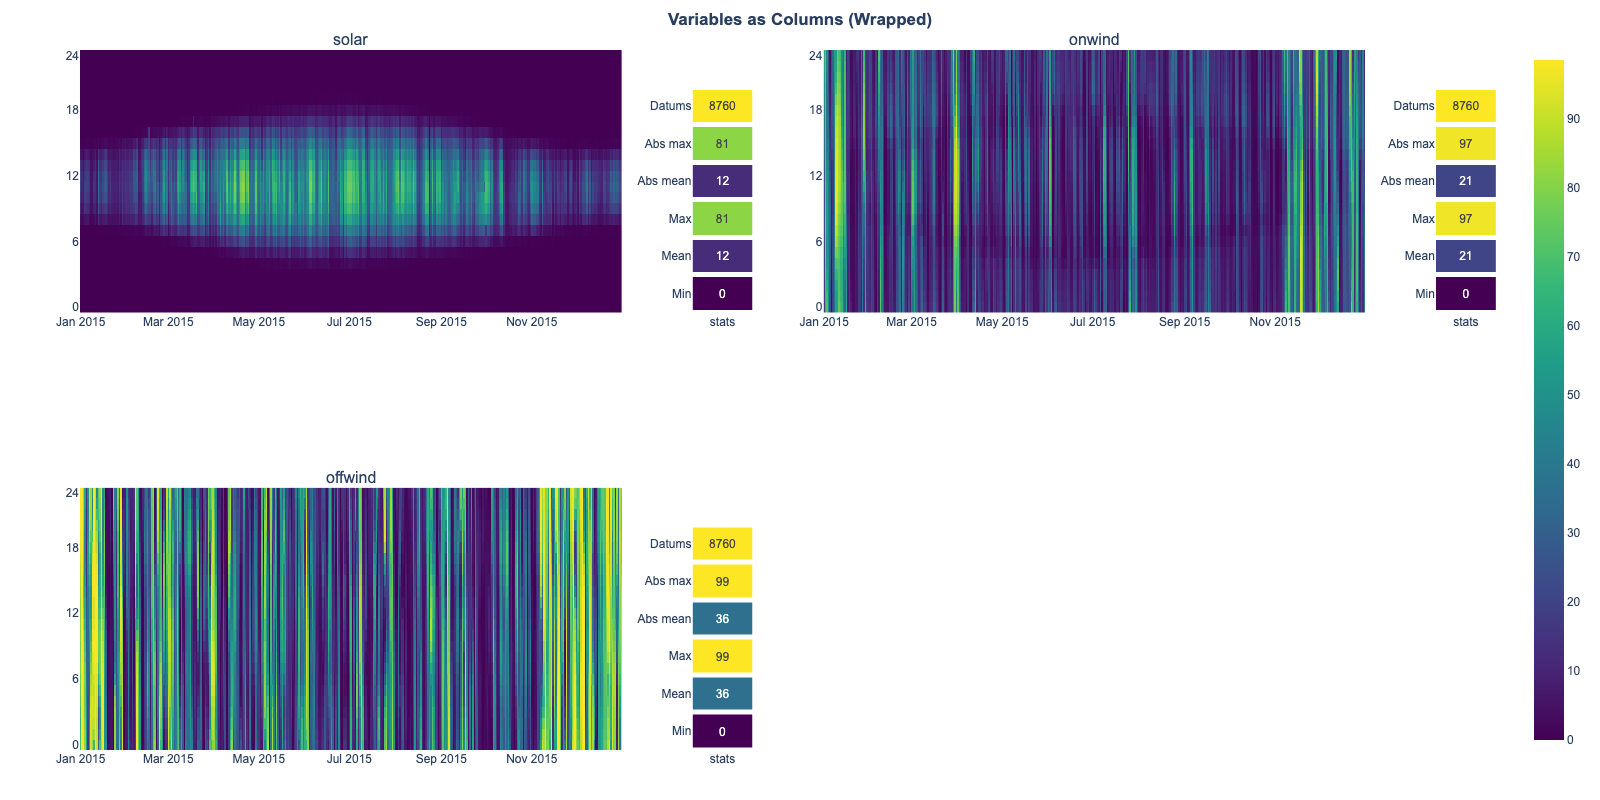

In [11]:
# Organizing variables as columns with wrapping
generator = TimeSeriesDashboardGenerator(
    x_axis='date',
    color_continuous_scale='viridis',
    facet_col='variable',
    facet_col_order=['solar', 'onwind', 'offwind'],
    facet_col_wrap=2  # Wrap after 2 columns
)

fig = generator.get_figure(df_res, title='Variables as Columns (Wrapped)')

renderer.show_plotly(fig)

## Multi-dimensional Facets (Scenarios × Variables)

Visualize multiple scenarios and variables in a grid layout.

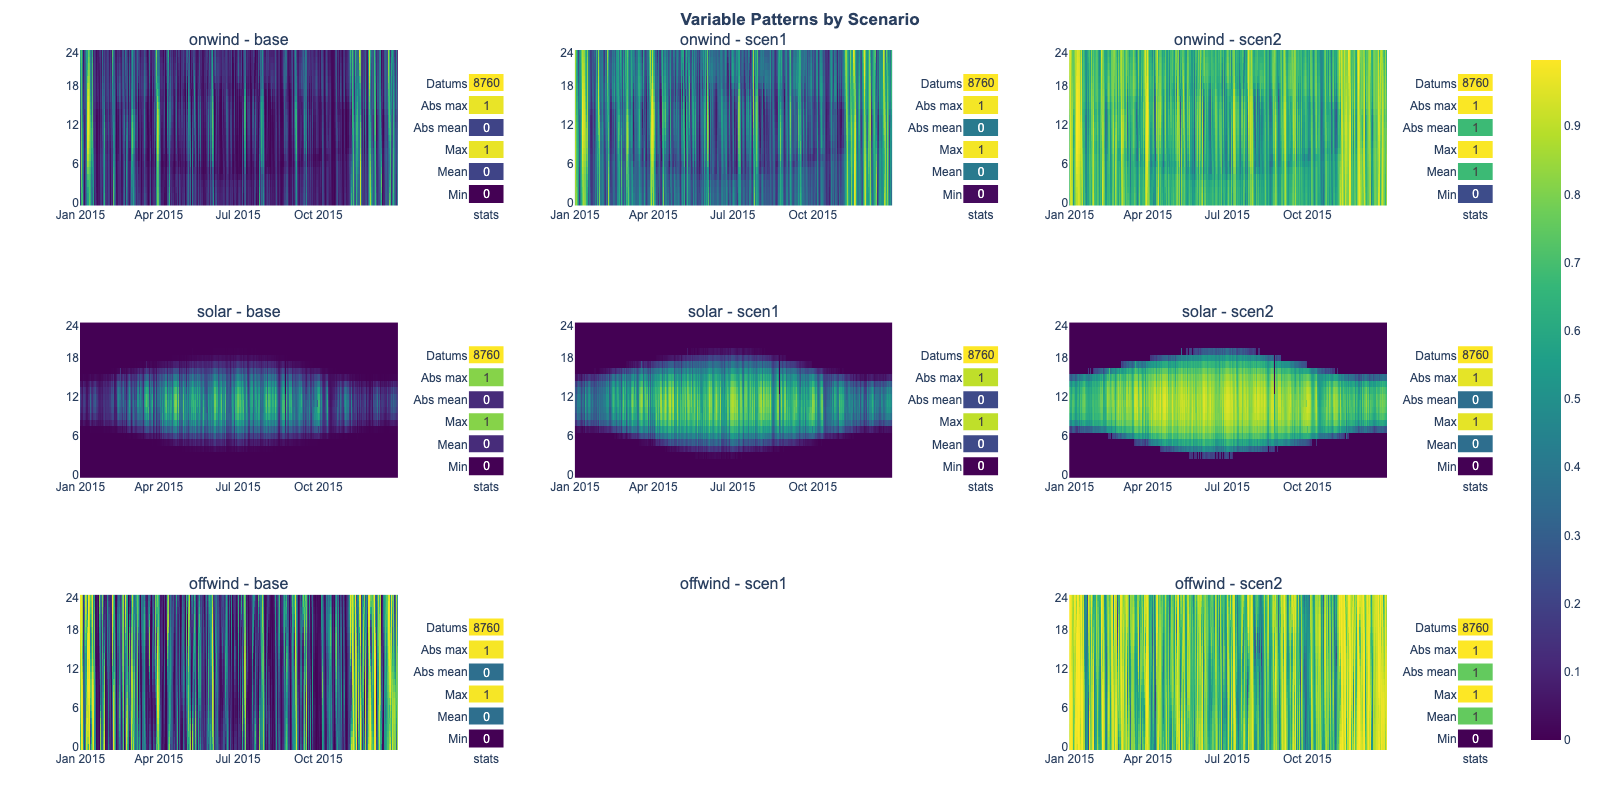

In [12]:
# Creating a grid of scenarios (columns) and variables (rows)
generator = TimeSeriesDashboardGenerator(
    x_axis='date',
    facet_col='dataset',  # Scenarios as columns
    facet_row='variable', # Variables as rows
    facet_col_order=['base', 'scen1', 'scen2'],
    facet_row_order=['onwind', 'solar', 'offwind'],
    color_continuous_scale='viridis',
    subplots_horizontal_spacing=0.05  # Adjust spacing between columns
)

fig = generator.get_figure(df_res_scenarios, title='Variable Patterns by Scenario')

renderer.show_plotly(fig)

## Custom Color Scales Per Variable

In many cases the different variables (or different objects / comparisons / scenarios) will have different orders-of-magnitude, making it useful to have a different color scale for the different categories. 

For this, just set `per_facet_row_colorscale` (or col) to True, and set the `facet_row_color_settings` (or col) accordingly. See an example below.

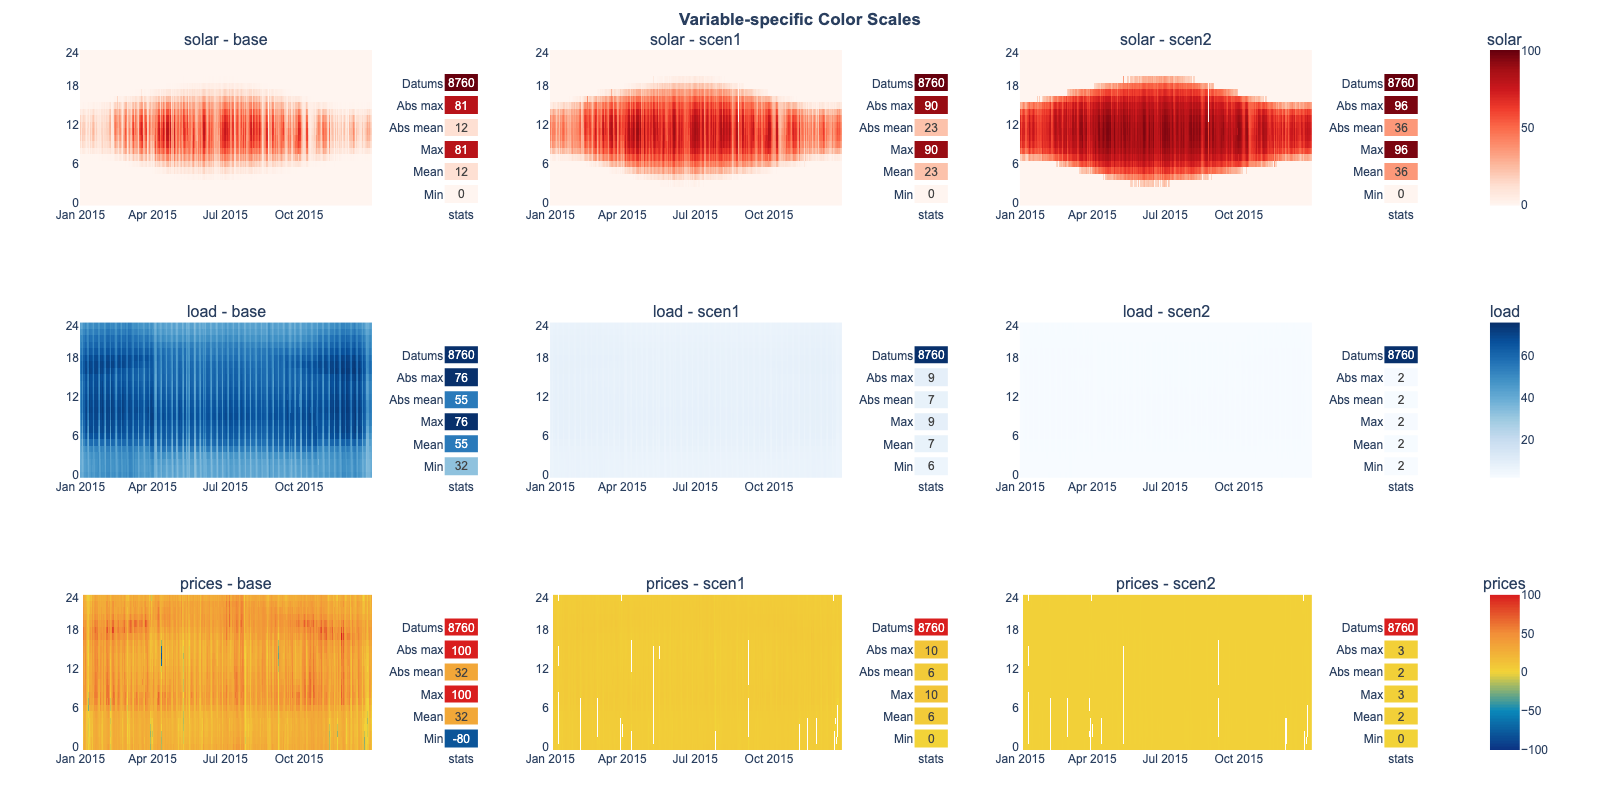

In [13]:
# Custom color scales by row (variable)
generator = TimeSeriesDashboardGenerator(
    x_axis='date',
    facet_col='dataset',
    facet_row='variable',
    facet_col_order=['base', 'scen1', 'scen2'],
    facet_row_order=['solar', 'load', 'prices'],
    per_facet_row_colorscale=True,              # Different color scale per row
    facet_row_color_settings={
        'solar': {'color_continuous_scale': 'Reds', 'range_color': [0, 100]},
        'load': {'color_continuous_scale': 'Blues'},
        'prices': {'color_continuous_scale': 'Portland', 'color_continuous_midpoint': 0},
    },
    subplots_horizontal_spacing=0.05  # Adjust spacing between columns
)

fig = generator.get_figure(df_mixed_scenarios, title='Variable-specific Color Scales')

renderer.show_plotly(fig)

## Multiple Time Aggregations

For the x_axis, you can also set a list of time aggregation methods, and then show them side-by-side (or row-by-row in case of facet_row, respectively).

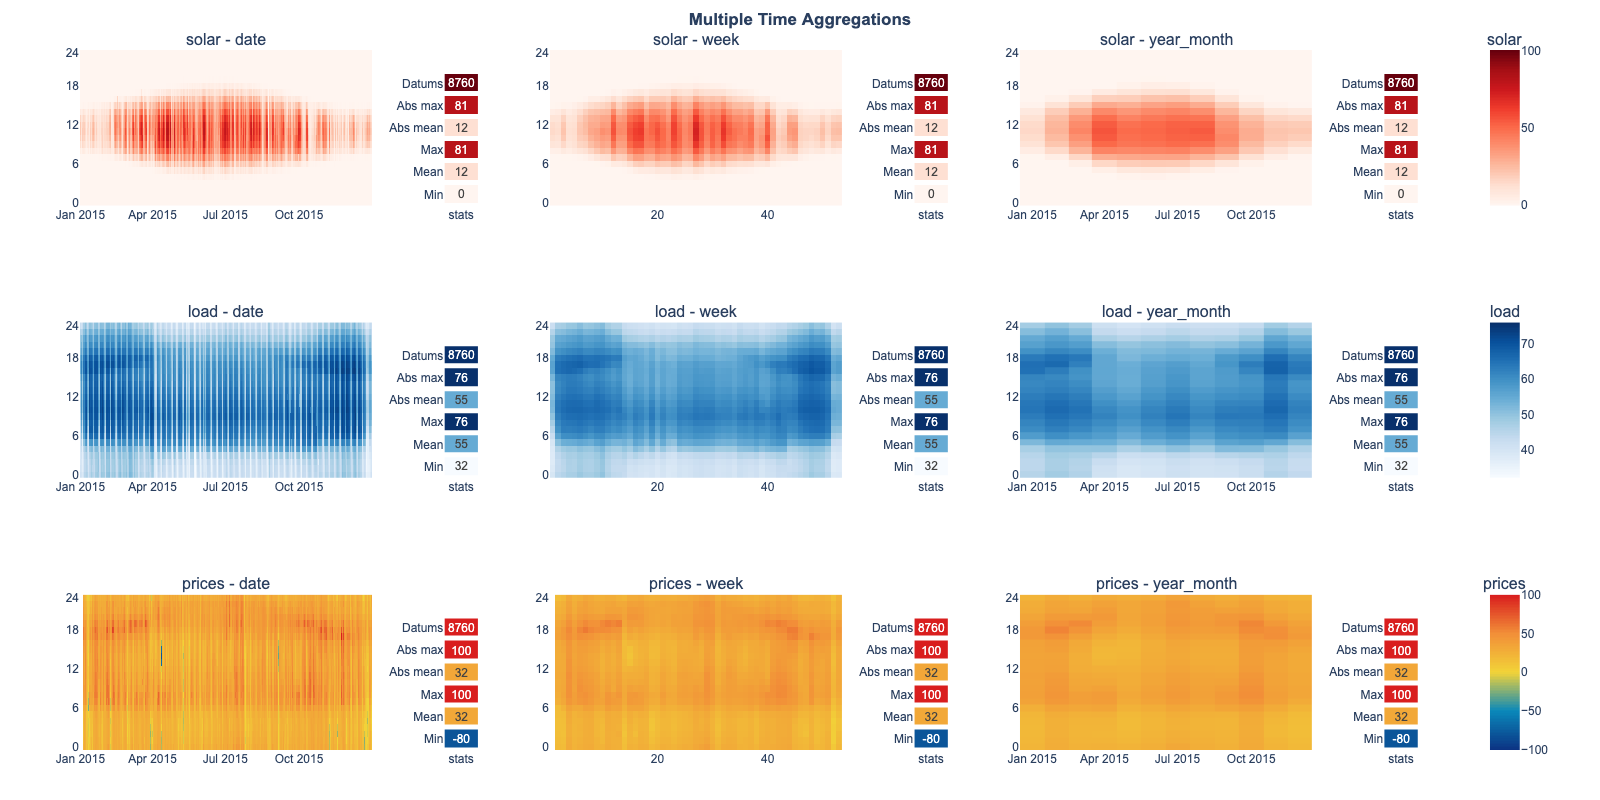

In [14]:
# Multiple x-axis time aggregations with custom color scales
generator = TimeSeriesDashboardGenerator(
    x_axis=['date', 'week', 'year_month'],      # Multiple time aggregations
    color_continuous_scale='viridis',
    facet_col='x_axis',                         # Aggregations as columns
    facet_row='variable',
    facet_row_order=['solar', 'load', 'prices'],
    per_facet_row_colorscale=True,
    facet_row_color_settings={
        'solar': {'color_continuous_scale': 'Reds', 'range_color': [0, 100]},
        'load': {'color_continuous_scale': 'Blues'},
        'prices': {'color_continuous_scale': 'Portland', 'color_continuous_midpoint': 0},
    },
    subplots_horizontal_spacing=0.05  # Adjust spacing between columns
)

fig = generator.get_figure(df_mixed, title='Multiple Time Aggregations')

renderer.show_plotly(fig)

## Statistical Aggregations

The same principle of setting multiple x_axis aggregations and comparing them can also be applied to Compare different statistical aggregations (min, mean, max) across each time-horizon.

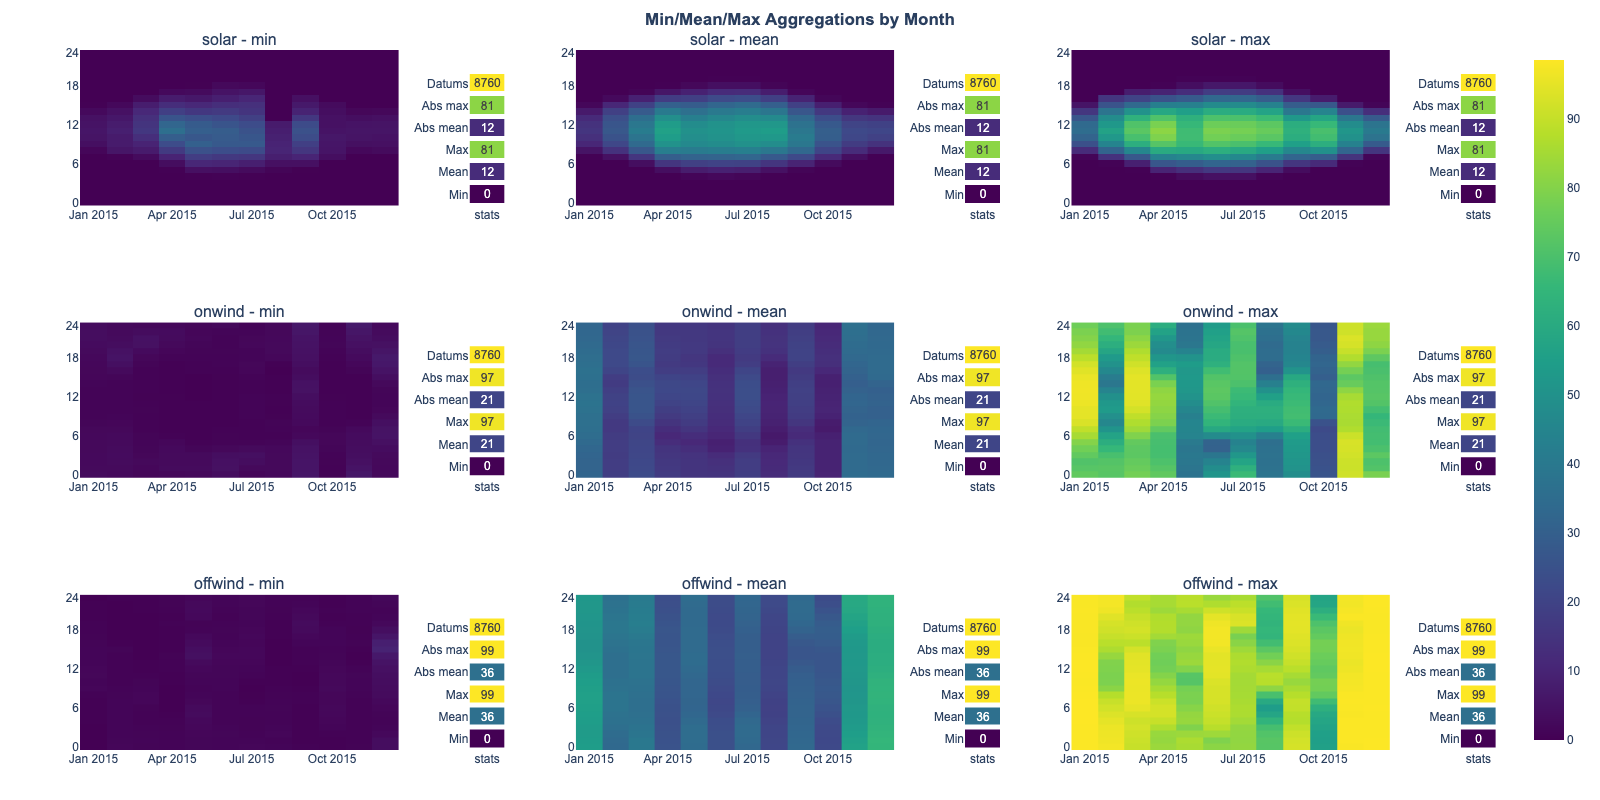

In [15]:
# Multiple statistical aggregations
generator = TimeSeriesDashboardGenerator(
    x_axis='year_month',                        # Aggregated per year and month
    facet_col='groupby_aggregation',            # Different stats as columns
    groupby_aggregation=['min', 'mean', 'max'], # Stats to calculate
    color_continuous_scale='viridis',
    facet_row='variable',
    facet_row_order=['solar', 'onwind', 'offwind'],
    subplots_horizontal_spacing=0.05  # Adjust spacing between columns
)

fig = generator.get_figure(df_res, title='Min/Mean/Max Aggregations by Month')

renderer.show_plotly(fig)

## Custom Colors Per Statistical Aggregation

The principle of custom color settings can, of course, also be applied per facet_col and in this case, for different statistical aggregations. Let's have a look.

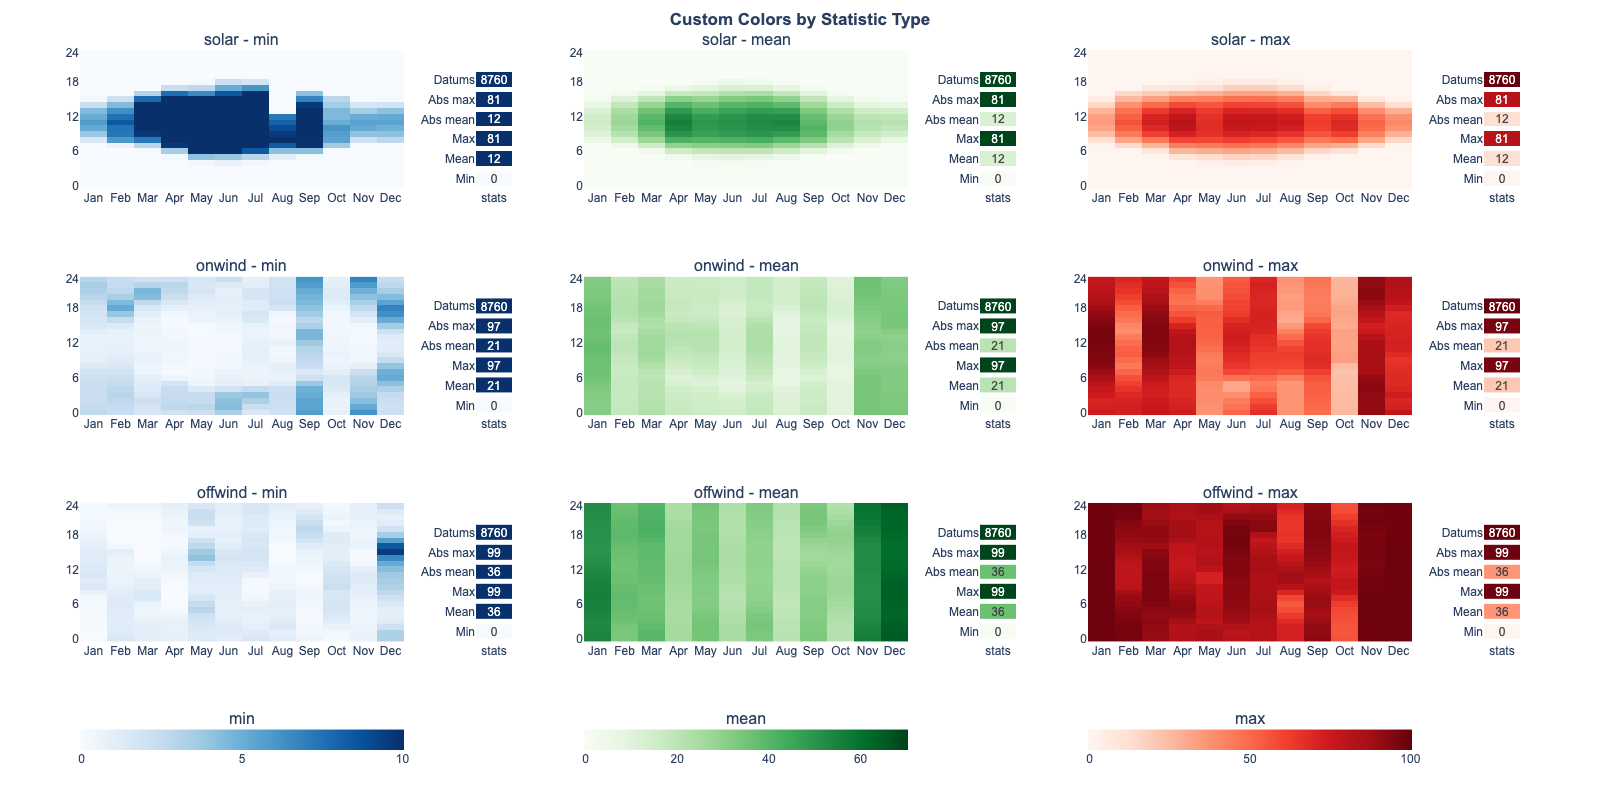

In [16]:
# Custom color scales per statistic type
generator = TimeSeriesDashboardGenerator(
    x_axis='month',
    facet_col='groupby_aggregation',
    groupby_aggregation=['min', 'mean', 'max'],
    facet_row='variable',
    facet_row_order=['solar', 'onwind', 'offwind'],
    per_facet_col_colorscale=True,  # Different color scale per column
    facet_col_color_settings={  # Color scales for columns
        'min': {'color_continuous_scale': 'Blues', 'range_color': [0, 10]},
        'mean': {'color_continuous_scale': 'Greens', 'range_color': [0, 70]},
        'max': {'color_continuous_scale': 'Reds', 'range_color': [0, 100]}
    },
    subplots_horizontal_spacing=0.05  # Adjust spacing between columns
)

fig = generator.get_figure(df_res, title='Custom Colors by Statistic Type')

renderer.show_plotly(fig)

## Conclusion

The TimeSeriesDashboard is a powerful tool for visualizing time-series data across multiple dimensions. Key benefits include:

- Revealing hourly patterns across days, weeks, or months
- Easy comparison of multiple scenarios, variables, objects, ...
- Easy detection of structural errors in your data
- KPI summaries alongside visualizations
- Highly customizable with flexible KPI summaries, categorical faceting, and color scales

Keep in mind, the TimeSeriesDashboard can be used as a standalone module, as long as you have your data in a pandas DataFrame format with a DatetimeIndex.
 
This module becomes especially powerful once you have your multi-scenario study loaded into a StudyManager, because the StudyManager gives you efficient access to the multi-scenario DataFrames in proper MultiIndex format.

Try for yourself! :)